# Group 4 Mathematics and Programming in Artificail intelligence

# Table of Contents:

1. [Why CIFAR-10](#why-cifar-10)
2. Task 1: NumPy Neural Network Implementation
   - [Activation Functions](#Activation-Functions)
   - [Softmax Layer](#Softmax-Layer)
   - [Dropout Implementation](#Dropout-Implementation)
   - [Neural Network Class](#neural-network-class)
   - [Optimisers](#optimisers)
   - [Network Evaluation and Results](#network-evaluation-and-results)
3. Task 2: PyTorch Implementation
   - [Dataset Preparation](#dataset-preparation)
   - [Evaluations which will be used to measure performance of each CNN variant](#evaluations-which-will-be-used-to-measure-performance-of-each-cnn-variant)
   - [Model Description and Implementation](#model-description-and-implementation)
   - [Improved model](#improved-model)
   - [optimised hyperparameters](#optimised-hyperparameters)
   - [Results and Discussion](#results-and-discussion)
4. [Conclusion and Reflection](#conclusion-and-reflection)

# Why CIFAR-10

We chose CIFAR-10 dataset due to its complexity and suitability in evaluating multi-layer neural networks. It holds 60,000 32x32 colour images spanning 10 diverse classes, crescendoing in a challenging classification task surpassing the likes of datasets like MNIST, which only holds grayscale digits. CIFAR-10 includes RGB images, demanding models to learn from more detailed and complex data, mirroring real world applications, where data is diverse and high dimensional. The aforementioned complexity allows rigorous testing of network architectures, activation functions, and techniques to optimise the model. Lastly, it has well documented benchmarks, and  widespread use in academic research making it a top candidate to showcase advanced implementations, setting the ground work for meaningful comparisons and evaluations.

## Imports:

In [2]:
#imports 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split, ConcatDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Task 1: NumPy Neural Network Implementation 

## Activation functions

### sigmoid functions and ReLU

In [14]:
class ActivationFunction:
    @staticmethod
    def sigmoidForward(x):
        '''
        this function does the forward pass of the sigmoid function
        it takes an input array i just called x 
        and it returns a tuple with the result (out) of the sigmoid function
        as well as cache which we use in the backward pass, its just the same as the out 
        '''
        out = 1/ (1+ np.exp(-x)) #the sigmoid function
        cache = out 
        return out, cache

    @staticmethod
    def sigmoidBackward(dout, cache):
        '''
        does the backward pass of the simoid function
        i used d to show that its the derivative 
        so dx is the gradient of the loss with resepct to x (the input array)
        dout is the upstream gradient
        sig is just the sigmoid function hence why it equals cache
        '''
        sig = cache
        dx = dout * sig * (1 - sig) #the derivative of the sigmoid function multiplied by the upstream gradient to get the proper flow of gradients
        return dx
    
    @staticmethod   
    def reluForward(x):
        '''
        does the forward pass of the ReLU function
        x is the input arry 
        and then it outputs a tuple with the result of the  ReLU forward pass as well a cache used for backward pass
        cache this time is the input array 
        '''
        out = np.maximum(0,x)
        cache = x 
        return out, cache
    @staticmethod
    def reluBackward(dout, cache):
        '''
        backward pass of the ReLU function
        x is just passing on the inpui arrat from forward pass using cache as the temporary store 
        dx is the gradient of the loss in respect to the input (being the array x)
        dout is the upstream gradient 
        '''
        x = cache 
        dx = dout * (x > 0) #derivative is 1 when x >0 otherwise it is 0
        return dx


## Softmax Layer

In [15]:
class SoftmaxLayer:
    def __init__(self):
        # Prepare to store the output of the softmax function
        self.output = None

    def forward(self, logits):
        """
        Perform the forward pass to calculate softmax probabilities.
        
        Parameters:
        logits (np.array): Scores from the previous layer, shaped (batch_size, num_classes).

        Returns:
        np.array: Probabilities for each class, same shape as input.
        """
        # Subtract the max to keep numbers stable
        z_max = np.max(logits, axis=1, keepdims=True)
        shifted_logits = logits - z_max
        exp_shifted = np.exp(shifted_logits)

        # Divide by sum of exponents to get probabilities
        sum_exp = np.sum(exp_shifted, axis=1, keepdims=True)
        self.output = exp_shifted / sum_exp
        return self.output

    def backward(self, true_labels):
        """
        Perform the backward pass to calculate gradient of the loss.
        
        Parameters:
        true_labels (np.array): One-hot encoded true class labels.

        Returns:
        np.array: Gradient of the loss with respect to logits.
        """
        # Get the number of samples to average the gradient
        num_samples = true_labels.shape[0]

        # Calculate the gradient for softmax combined with cross-entropy
        gradient = (self.output - true_labels) / num_samples
        return gradient

if __name__ == "__main__":
    # Example usage of SoftmaxLayer

    # Define example logits, representing class scores
    logits_example = np.array([[2.0, 1.0, 0.1],
                               [1.0, 2.0, 0.1]])

    # Define the true labels in one-hot encoding
    true_labels_example = np.array([[1, 0, 0],
                                    [0, 1, 0]])

    # Instantiate the softmax layer
    softmax_layer = SoftmaxLayer()

    # Forward pass to get probability distributions
    softmax_output = softmax_layer.forward(logits_example)
    print("Softmax Probabilities:\n", softmax_output)

    # Backward pass to compute gradient
    loss_gradient = softmax_layer.backward(true_labels_example)
    print("Gradient of Loss w.r.t Logits:\n", loss_gradient)


Softmax Probabilities:
 [[0.65900114 0.24243297 0.09856589]
 [0.24243297 0.65900114 0.09856589]]
Gradient of Loss w.r.t Logits:
 [[-0.17049943  0.12121649  0.04928295]
 [ 0.12121649 -0.17049943  0.04928295]]


## Dropout Implementation 

In [16]:
class Dropout:
    """
    Author: Abdelrahmane Bekhli
    Date: 2024-11-18
    Description: This class performs dropouts.
    """
    def __init__(self, dropoutRate, seed=None):
        """ 
        Initialize the Dropout layer. 
        Args: 
            dropoutRate (float): The probability of dropping out a unit. 
            seed (int, optional): Random seed for reproducibility. 
        """
        if not (0 <= dropoutRate < 1):
            raise ValueError("Dropout rate must be between 0 and 1")
        self.dropoutRate = dropoutRate
        self.mask = None
        self.training = True
        if seed is not None:
            np.random.seed(seed)
    
    def forward(self, x):
        """
        Forward pass for dropout.
        Args:
            x (numpy array): The input to the dropout layer.
        Returns:
            numpy array: Output after applying dropout.
        """
        if self.training:
            self.mask = np.random.rand(*x.shape) > self.dropoutRate
            return x * self.mask / (1 - self.dropoutRate)
        else:
            return x
    
    def backward(self, dout):
        """
        Backward pass for dropout.
        Args:
            dout (numpy array): The gradient from the next layer.
        Returns:
            numpy array: Gradient after applying dropout mask.
        """
        return dout * self.mask / (1 - self.dropoutRate)
    
    def setMode(self, mode):
        """
        Set the mode for the network: 'train' or 'test'
        Args:
            mode (str): Either 'train' or 'test'.
        """
        if mode == 'train':
            self.training = True
        elif mode == 'test':
            self.training = False
        else:
            raise ValueError("Mode can only be 'train' or 'test'")
        self.mask = None # reset mask when changing modes

# Task 2: PyTorch Implementation

## Dataset Preparation

In [4]:

# Check if a GPU is open, if it is use CUDA for faster computation, if not go with CPU 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop a patch that is 32x32 with padding, improving robustness to spatial shifts
    transforms.RandomHorizontalFlip(),  # Flip the image horizontally to augment data 
    transforms.ToTensor(),  # Convert from PIL to PyTorch tensors format
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Add color jitter to simulate varied lighting conditions
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images to have a mean of 0.5 and std of 0.5 for stability
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Only normalize test data; augmentation not needed during evaluation
])

# Load CIFAR-10 dataset with the specified transformations
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# Concatenate the training and test datasets
combined_data = ConcatDataset([train_data, test_data])

# train/validation split ratio
train_size = int(0.72 * len(combined_data))  # 72% for training
validation_size = int(0.18 * len(combined_data))  # 18% for validation
test_size = int(0.10 * len(combined_data))  # 10% for testing 

# Split the combined data into train, validate and test sets, in a randomized manner but with a fixed seed to ensure reproducibility of the results
generator = torch.Generator().manual_seed(42)
train_data, validation_data, test_data = random_split(combined_data, [train_size, validation_size, test_size], generator)

# Create data loaders for train, validation, and test sets
load_train = DataLoader(train_data, batch_size=64, shuffle=True)  # Training data is in random order to help training
load_validation = DataLoader(validation_data, batch_size=64, shuffle=False)  # No shuffling for validation data
load_test = DataLoader(test_data, batch_size=64, shuffle=False)  # No shuffling for test data


Files already downloaded and verified
Files already downloaded and verified


## Evaluations which will be used to measure performance of each CNN variant

In [6]:
# made a class with all the evaluations i will use for my models to compare and illustrate their performance 
class ModelEvaluator:
    #initialise with the attributes that we will use
    def __init__(self, model, optimiser, criterion, device, load_train, load_validation, load_test, class_labels):
        self.model = model
        self.optimiser = optimiser
        self.criterion = criterion
        self.device = device
        self.load_train = load_train
        self.load_validation = load_validation
        self.load_test = load_test
        self.class_labels = class_labels 

        #initialise empty list so that metrics can be tracked as training goes on
        self.train_losses = []
        self.validation_losses = []
        self.accuracies = []
        self.all_labels = []
        self.all_predictions = []
        self.learning_rates = []

    def store_learning_rate(self):
        lr = [group['lr'] for group in self.optimiser.param_groups] #gets the learning rate currently in use from the optimser
        self.learning_rates.append(lr[0]) #adds that to a learning rates list to visualise wehn we draw grath

    def evaluate_epoch(self, epoch):
        self.model.eval() #puts model from training to evaluation mode, turning off droupt and batch updates
        # init validation loss and counters for accuracy, also clear the previous lables and predictions for the epoch
        validation_loss = 0.0 
        correct, total = 0, 0
        self.all_labels.clear()
        self.all_predictions.clear()

        #goes through the set without calculating gradients, computes: prediction, loss anad stores the actual labels as well as the predicted labels 
        with torch.no_grad():
            for inputs, labels in self.load_validation:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                self.all_labels.extend(labels.cpu().numpy())
                self.all_predictions.extend(predicted.cpu().numpy())

        #compute the average validation loss as well as the accuracy for the epoch
        average_validation_loss = validation_loss / len(self.load_validation)
        accuracy = 100 * correct / total
        #appends those results in the lists 
        self.validation_losses.append(average_validation_loss)
        self.accuracies.append(accuracy)
        print(f"Epoch {epoch+1}: Validation Loss: {average_validation_loss:.4f}, Accuracy: {accuracy:.2f}%")

#plotting accuracy plot
    def plot_accuracy(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.accuracies)+1), self.accuracies, marker='o', linestyle='-', color='b')
        plt.title("Model Accuracy Over Training")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    
#validation loss plot 
    def plot_validation_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.validation_losses)+1), self.validation_losses, marker='o', linestyle='-', color='r')
        plt.title("Model Validation Loss Over Training")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#training loss plot
    def plot_training_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.train_losses)+1), self.train_losses, marker='o', linestyle='-', color='g')
        plt.title("Model Training Loss Over Training")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#confusion matrix
    def plot_confusion_matrix(self):
        #makes a confusion matrix to show the perfomance of the classification
        cm = confusion_matrix(self.all_labels, self.all_predictions)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.7)
        #inputts the numerical values to the matrix 
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', color='black', fontsize=12)

        #addinf the lables and titles so its easy to read 
        # Use the original dataset for class labels
    

        ax.set_xticks(range(len(self.class_labels)))
        ax.set_xticklabels(self.class_labels, rotation=45, ha="right")
        ax.set_yticks(range(len(self.class_labels)))
        ax.set_yticklabels(self.class_labels)

        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    # Output a classification report
    def print_classification_report(self):
        # Use self.class_labels instead of accessing from the dataset
        report = classification_report(self.all_labels, self.all_predictions, target_names=self.class_labels)
        print("\nClassification Report:\n")
        print(report)

#plot a preciison recall curve 
    def plot_precision_recall_curve(self):
        #computes the curve for each class
        plt.figure(figsize=(10, 5))
        for i, class_name in enumerate(self.class_labels):
            precision, recall, _ = precision_recall_curve(
                np.array(self.all_labels) == i, np.array(self.all_predictions) == i
            )
            plt.plot(recall, precision, label=f'Class: {class_name}')
        #displays it 
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#learning rate plot
    def plot_learning_rate(self):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(self.learning_rates)+1), self.learning_rates, marker='o', linestyle='-', color='m')
        plt.title("Learning Rate Schedule")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

#figure out the top 5 accuracy, which is good for multi-class problems 
    def calculate_top5_accuracy(self):
        correct_top5, total_top5 = 0, 0
        with torch.no_grad():
            for inputs, labels in self.load_validation:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, top5_predictions = outputs.topk(5, dim=1)
                correct_top5 += (top5_predictions == labels.unsqueeze(1)).sum().item()
                total_top5 += labels.size(0)
        top5_accuracy = 100 * correct_top5 / total_top5
        print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

#ROC CURVE 
    def plot_roc_curve(self):
        #compute and plit teh ROC curve with the AUC score 
        labels_bin = label_binarize(self.all_labels, classes=range(len(self.class_labels)))
        plt.figure(figsize=(10, 5))
        for i, class_name in enumerate(self.class_labels):
            fpr, tpr, _ = roc_curve(labels_bin[:, i], np.array(self.all_predictions) == i)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="best")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


# CNN model 

## Model Description and Implementation

### Description
We utilised a Convolutional Neural Network (CNN) model for this task as it is degined to efficiently learn hierarchical image features from low resolutions like 32 by 32 rgb images. The model is made up of three layers, each with increasing filter sizes be that 32,64 or 128 as well as 3 by 3 kernels, each followed by batch normalisation, ReLU activation, and max-pooling which reduces spatiali dimensions while maintaining critical features. 
After the aformentioned convolution stages, the network contains two fully connected layers, the first with 256 neurons and ReLU activation, which is then followed by dropout to prevent overfitting,
the second includes 10 output neurorns representing classs probabilities for CIFAR-10's different categories.
The model we have implemented leverages standard PyTorch components as well as cross-entropy to optimise accuracy in classification problems.

### justification
A CNN architecture is well suited for a dataset like CIFAR-10 due to its inate ability to learn complex spatial hierarchies by utilising layered convolutional operations, extreacting patterns such as textures, objects, and edges. 
The chosen model balances complexity with efficiency by making use of three convolutional layers, this allows computation to remain manageable while still capturing the most essential features.
Batch normalisation enables stable and faster convergence, while making use of dropout prevents overfitting on the dataset which is relatively small.
By combining max-pooling and fully connceted layers the model is able to have an optimal tradeoff between performance and training efficiency. In my opinion this all makes the Convolutional Neural Network an effective architecture for our chosen dataset.


Epoch 1/20, Loss: 1.6238
Epoch 1: Validation Loss: 1.3229, Accuracy: 51.99%
Epoch 2/20, Loss: 1.3085
Epoch 2: Validation Loss: 1.0986, Accuracy: 61.00%
Epoch 3/20, Loss: 1.1751
Epoch 3: Validation Loss: 0.9681, Accuracy: 64.94%
Epoch 4/20, Loss: 1.0912
Epoch 4: Validation Loss: 0.9124, Accuracy: 67.27%
Epoch 5/20, Loss: 1.0247
Epoch 5: Validation Loss: 0.8785, Accuracy: 68.72%
Epoch 6/20, Loss: 0.9802
Epoch 6: Validation Loss: 0.8715, Accuracy: 69.34%
Epoch 7/20, Loss: 0.9355
Epoch 7: Validation Loss: 0.8515, Accuracy: 69.81%
Epoch 8/20, Loss: 0.9093
Epoch 8: Validation Loss: 0.8367, Accuracy: 70.38%
Epoch 9/20, Loss: 0.8765
Epoch 9: Validation Loss: 0.7844, Accuracy: 71.94%
Epoch 10/20, Loss: 0.8485
Epoch 10: Validation Loss: 0.8208, Accuracy: 71.83%
Epoch 11/20, Loss: 0.8226
Epoch 11: Validation Loss: 0.7612, Accuracy: 73.49%
Epoch 12/20, Loss: 0.8071
Epoch 12: Validation Loss: 0.7250, Accuracy: 74.82%
Epoch 13/20, Loss: 0.7837
Epoch 13: Validation Loss: 0.6982, Accuracy: 75.19%
Epoc

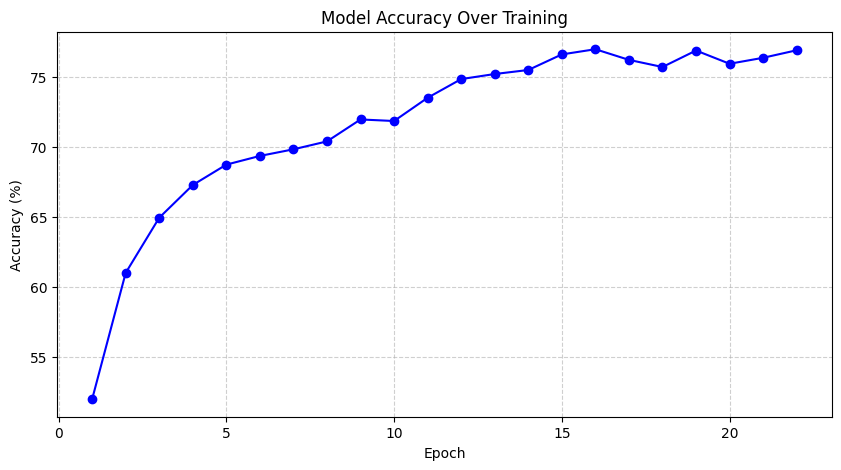

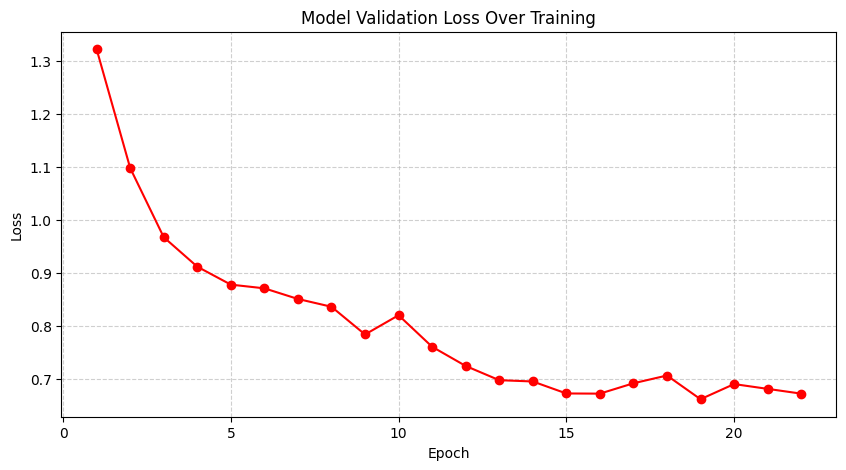

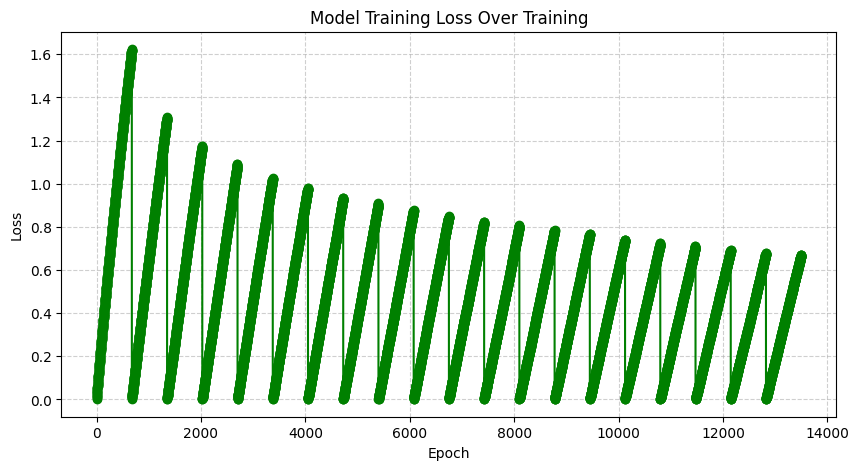

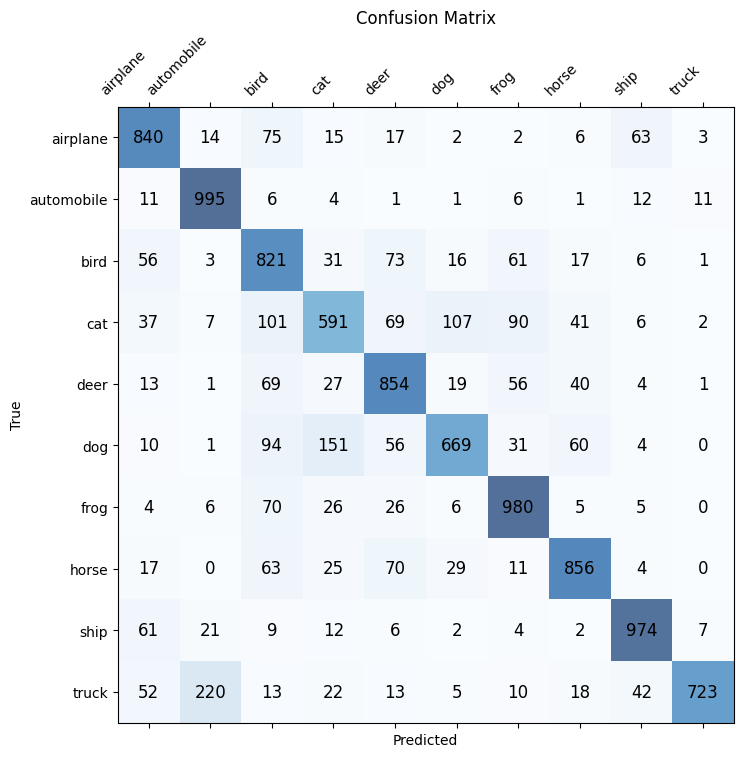


Classification Report:

              precision    recall  f1-score   support

    airplane       0.76      0.81      0.79      1037
  automobile       0.78      0.95      0.86      1048
        bird       0.62      0.76      0.68      1085
         cat       0.65      0.56      0.60      1051
        deer       0.72      0.79      0.75      1084
         dog       0.78      0.62      0.69      1076
        frog       0.78      0.87      0.82      1128
       horse       0.82      0.80      0.81      1075
        ship       0.87      0.89      0.88      1098
       truck       0.97      0.65      0.77      1118

    accuracy                           0.77     10800
   macro avg       0.78      0.77      0.77     10800
weighted avg       0.78      0.77      0.77     10800



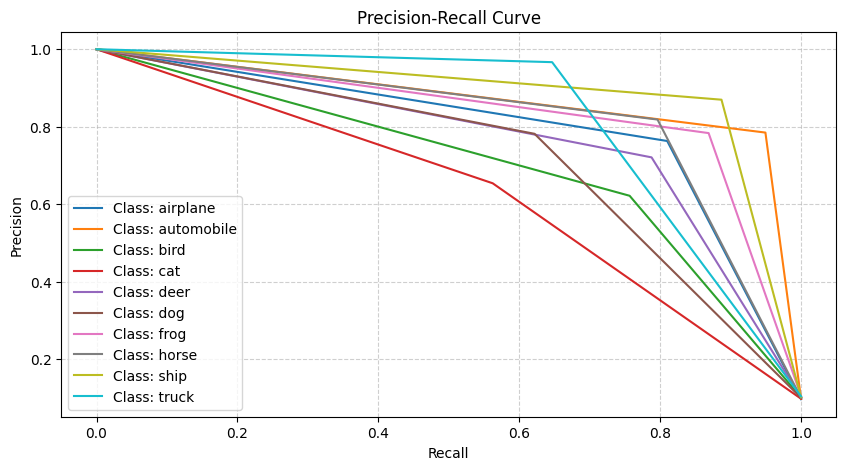

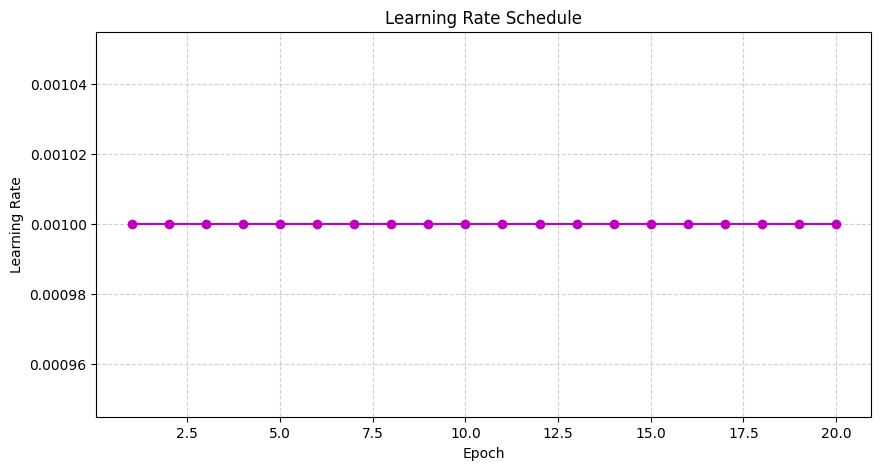

Top-5 Accuracy: 98.47%


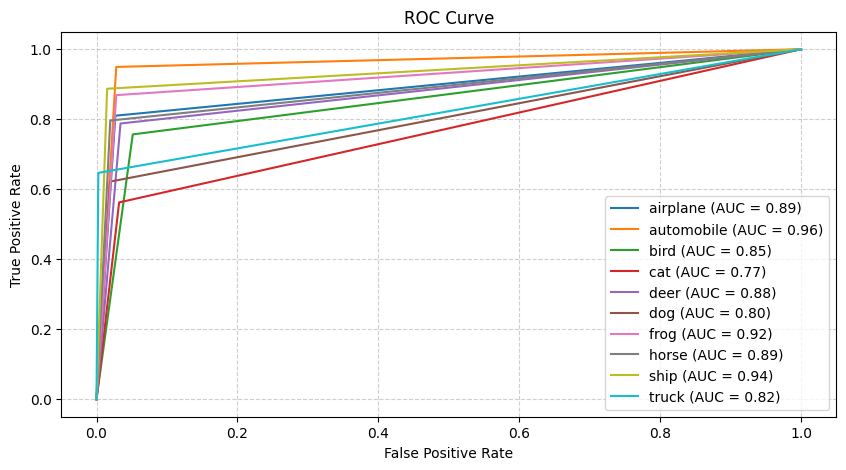

In [10]:

# defining CNNModel
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #convolutional layers 
        self.convolution1 = nn.Conv2d(3,32, kernel_size= 3, padding = 1) #conv2d applies 2d convolution
        self.normaliseBatch1 = nn.BatchNorm2d(32) #normalise each batch activation to have training be stable and speed up convergence 
        self.convolution2 = nn.Conv2d(32,64, kernel_size= 3, padding =1)
        self.normaliseBatch2 = nn.BatchNorm2d(64)
        self.convolution3 = nn.Conv2d(64,128, kernel_size=3, padding =1)
        self.normaliseBatch3 = nn.BatchNorm2d(128)
    
        self.pool = nn.MaxPool2d(2,2) #reduce dimensions, takes the max value in a 2 by 2 window, halves the width and heigth
        # fully connected layer 
        self.fc1 = nn.Linear(128 * 4 * 4, 256) #input flattend output from last convolutional layer 
        self.fc2 = nn.Linear(256, 10) # output 256 in the first layer, 10 in the last 
        self.dropout = nn.Dropout(0.5) #randomly deactive half the neurons as to not oevrfit 
        self.relu = nn.ReLU() # apply activation fucntuion relu 

    def forward(self, x):
        #the following three functions normalise activations, make it non-linear, reduce spatial dimension
        x = self.pool(self.relu(self.normaliseBatch1(self.convolution1(x)))) 
        x = self.pool(self.relu(self.normaliseBatch2(self.convolution2(x))))
        x = self.pool(self.relu(self.normaliseBatch3(self.convolution3(x))))
        x = x.view(-1, 128 * 4 * 4)  # 2d features to 1d for fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))  #regularsing the flattened output after beiong passed through the first fully connected layer
        x = self.fc2(x) #passes the output through the second fully connnected layer to get class score 
        return x #the raw prediction scores for each class in the dataaset


CNNModel = CNN().to(device) #initialise and move to the device that we prepared in the above module
criterion = nn.CrossEntropyLoss() #to get the difference between predictions and ground truth
optimiser = optim.Adam(CNNModel.parameters(), lr=0.001) #adjusts the weights in the CNNModel based on the gradients

# Extract class labels from the original dataset
class_labels = torchvision.datasets.CIFAR10(root='./data', train=True, download=False).classes
 # This will give you the class names
# Create an instance of ModelEvaluator after training
evaluator = ModelEvaluator(CNNModel, optimiser, criterion, device, load_train, load_validation, load_test, class_labels)


#loop for training
epochs = 20 #training will iterate through 20 epochs over the whole dataset
for epoch in range(epochs): #processed training for every epoch 
    CNNModel.train() #enables training and activates dropout
    running_loss = 0.0  #initiate the loss counter which will be used to calc the average loss
    for inputs, labels in load_train: #loops through the branches training data we had made in the data loader above
        inputs, labels = inputs.to(device), labels.to(device) # move both the image tensors from the current batch, and the corresponging true class lables to the selcted device
        optimiser.zero_grad() #reset gradient from previous iteration of training 
        outputs = CNNModel(inputs) #forward pass, feeds input through the cnn, generating predictions for the batch
        loss = criterion(outputs, labels) #calculating the loss function between predictions and labels using cross entropy loss 
        loss.backward() #back propagation gives us the gradient 
        optimiser.step() #update the parameters using the calculated gradient
        running_loss += loss.item() #keeps track of the average loss per epoch 
        average_train_loss = running_loss / len(load_train)
        evaluator.train_losses.append(average_train_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(load_train):.4f}") #output the current average loss for the epoch

 # Evaluate on Validation Set After Each Epoch
    evaluator.evaluate_epoch(epoch)
    evaluator.store_learning_rate()

CNNModel.eval() #switch from training to evaluation

# Evaluate CNNModel on the validation set after all epochs
evaluator.evaluate_epoch(epochs - 1)

#initialise the metrics
correct = 0  #correct classifiers
total = 0 #number of imaged evaluated
with torch.no_grad(): #to save some memory prevent gradient computation while inference is running 
    for inputs, labels in load_validation: #go through test set
        inputs, labels = inputs.to(device), labels.to(device) #move the images and corresponding lables to the device selected
        outputs = CNNModel(inputs) #forward pass inputs into the cnn CNNModel, giving us a tensor with the raw prediction scores from the final layer
        _, predicted = torch.max(outputs, 1) #choose the class with the higherst prediction score, return the predicted class index, the maximum vaye itseld is not used.
        total += labels.size(0) #increase total by number of images in the batch to keep track of the ones processed
        correct += (predicted == labels).sum().item() #compare prediction with labels

final_validation_accuracy = 100 * correct / total
print(f"Final Validation Accuracy: {final_validation_accuracy:.2f}%") #prints out the calculated accuracy % to 2 decimal places

# Evaluate CNNModel on the test set
evaluator.evaluate_epoch(epochs - 1)

# Call all evaluation methods
evaluator.plot_accuracy()               # Plot Accuracy
evaluator.plot_validation_loss()        # Plot Validation Loss
evaluator.plot_training_loss()          # Plot Training Loss
evaluator.plot_confusion_matrix()       # Confusion Matrix
evaluator.print_classification_report() # Classification Report
evaluator.plot_precision_recall_curve()# Precision-Recall Curve
evaluator.plot_learning_rate()          # Learning Rate Plot
evaluator.calculate_top5_accuracy()       # Top-5 Accuracy
evaluator.plot_roc_curve()              # ROC Curve




## Improved model

### Added extra convolutinal layer
CNNs work on the principle of learning higher level features proggressively from input iages through a number of convolutional, activation, and pooling layers, each layer extracts features from the pictures at a differenat level of complexity:
The first layer looks out for basic patterns like edges, simple shapes, and textures
The second layer combines these basic patters making larger more complex features
The third layer observes more abstracts features whihc could be things like object parts
Lastly the fourth layer which we added will combine the high level features so that it is able to create a meaningful representation of the objects in the picture.

The reason behind me adding this extra layer is the following:
1. avoid the model underfitting to the data, by adding an extra layer, the chance of the model not capturing the complexity of the data is lower, therefore allowing the model to have a notion of more intricate relationship between features.
2. the extra convolutional layer, can become awware more complex features which may be overlooked by a model with only 3 layers, this in turn increases representational power.
3. A dataset like CIFAR-10 includes images with vairous different scales and objects of different sizes. A deeper more thorough network will perform better at capturing these occasions 

### Used a learning rate shceduler

A learning scheduler makes use of specific strategies to adjust the learning rate which is used during training dynamically. The strategy I went for was ReduceLROnPlateau, which allows the model to reduce the learning rate by a factor whenever the validation loss plateaus.

My motivation behind this choice lies in the following thoughts:
1. giving automatic control to change the learning rate whenever the validation loss stops improving, removing the need for us to manually make those adjustments, leading to a simpler training process
2. As a high learning rate can at certain points cause the halting of improvements, having it change as required allows us to maintain our models abiltiy to improve, due to removing the risk of oscillating between optimal weights
3. By decreasing the size of the steps the model takes when training, allows the model to settle at a more optimal solution rather then if the learning rate was constant while still maintainig efficency and ensuring overshooting doesn't occur once the minima is reached 
4. Higher learning rates at the start help models converge faster, while lowering the learning rate later on leads us to the previous point.

I settled on ReduceLROnPlateau as it monitors the validation loss directly, only adjusting learning rates when no improvements are observed.

Epoch 1/20, Training Loss: 1.5539
Epoch 1: Validation Loss: 1.2632, Accuracy: 53.69%
Validation Loss: 2.2828, Accuracy: 53.31%
Epoch 2/20, Training Loss: 1.1856
Epoch 2: Validation Loss: 1.1256, Accuracy: 59.38%
Validation Loss: 2.0210, Accuracy: 59.38%
Epoch 3/20, Training Loss: 1.0298
Epoch 3: Validation Loss: 0.9841, Accuracy: 65.47%
Validation Loss: 1.7644, Accuracy: 65.95%
Epoch 4/20, Training Loss: 0.9298
Epoch 4: Validation Loss: 0.8342, Accuracy: 70.51%
Validation Loss: 1.5106, Accuracy: 70.63%
Epoch 5/20, Training Loss: 0.8601
Epoch 5: Validation Loss: 0.8014, Accuracy: 71.94%
Validation Loss: 1.4307, Accuracy: 72.04%
Epoch 6/20, Training Loss: 0.8046
Epoch 6: Validation Loss: 0.7669, Accuracy: 73.24%
Validation Loss: 1.3541, Accuracy: 73.65%
Epoch 7/20, Training Loss: 0.7559
Epoch 7: Validation Loss: 0.8325, Accuracy: 71.41%
Validation Loss: 1.4916, Accuracy: 70.82%
Epoch 8/20, Training Loss: 0.7164
Epoch 8: Validation Loss: 0.6989, Accuracy: 75.03%
Validation Loss: 1.2504, A

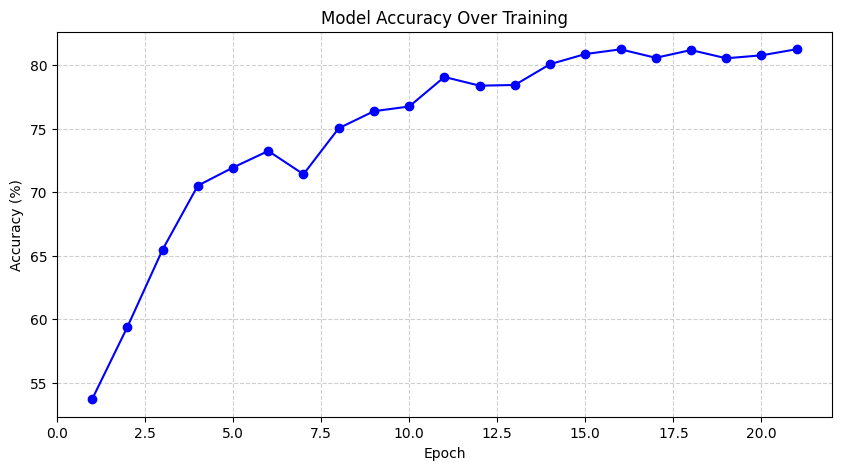

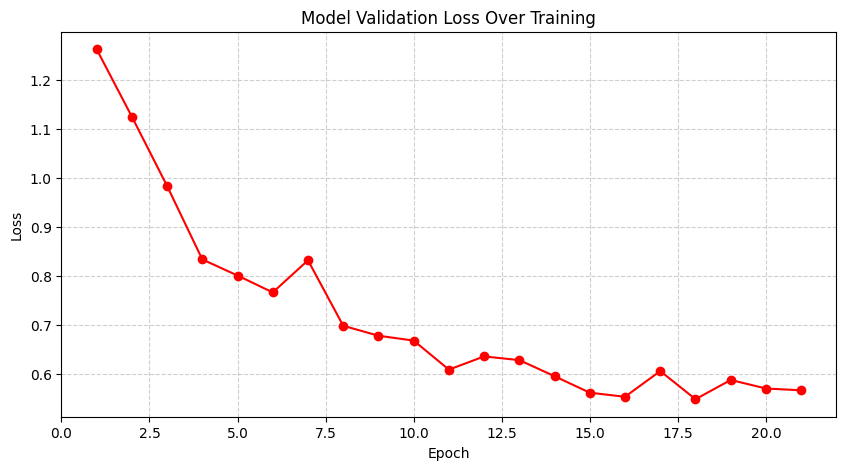

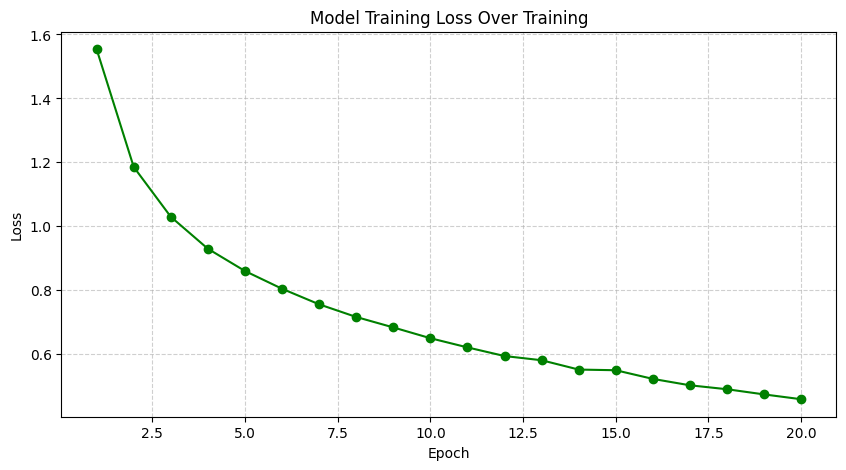

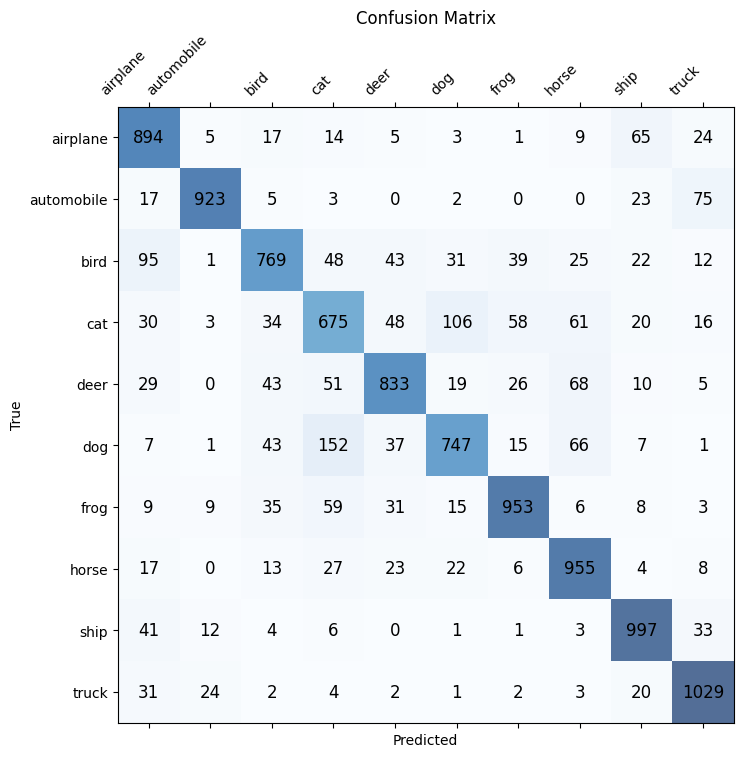


Classification Report:

              precision    recall  f1-score   support

    airplane       0.76      0.86      0.81      1037
  automobile       0.94      0.88      0.91      1048
        bird       0.80      0.71      0.75      1085
         cat       0.65      0.64      0.65      1051
        deer       0.82      0.77      0.79      1084
         dog       0.79      0.69      0.74      1076
        frog       0.87      0.84      0.86      1128
       horse       0.80      0.89      0.84      1075
        ship       0.85      0.91      0.88      1098
       truck       0.85      0.92      0.89      1118

    accuracy                           0.81     10800
   macro avg       0.81      0.81      0.81     10800
weighted avg       0.81      0.81      0.81     10800

Top-5 Accuracy: 98.61%


In [8]:
# Improved CNN Model I will only be adding comments which wouldn't be a repeat of the base class ones
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Convolutional Layers
        self.convolution1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.normaliseBatch1 = nn.BatchNorm2d(32)
        
        self.convolution2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.normaliseBatch2 = nn.BatchNorm2d(64)
        
        self.convolution3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.normaliseBatch3 = nn.BatchNorm2d(128)
        
        # Added Fourth Convolutional Layer
        self.convolution4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.normaliseBatch4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 2 * 2, 256) # Same as original Model
        self.fc2 = nn.Linear(256, 10)
        
        self.dropout = nn.Dropout(0.5) # Same as original Model
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.normaliseBatch1(self.convolution1(x))))
        x = self.pool(self.relu(self.normaliseBatch2(self.convolution2(x))))
        x = self.pool(self.relu(self.normaliseBatch3(self.convolution3(x))))
        x = self.pool(self.relu(self.normaliseBatch4(self.convolution4(x))))
        x = x.view(-1, 256 * 2 * 2) # due to the fourth convolution layer the output channel size increases
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialise Model, Loss, and Optimizer
ImprovedModel = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(ImprovedModel.parameters(), lr=0.001) # Same as original ImprovedModel
#schduler reduces learning rate of the optimiser when teh learning rate stops improving, reduces lr by a factor of 0.5, 
#patience is how long to wait after last improvement to reduce lr again, so if validation loss does not improve after 3 epochs, lr is reduced by a factor of 0.5
#verbose shows a message when lr is reduced 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=3, verbose=True)

# Extract class labels from the original dataset
class_labels = torchvision.datasets.CIFAR10(root='./data', train=True, download=False).classes
 # This will give you the class names
# Create an instance of ModelEvaluator after training
evaluator = ModelEvaluator(ImprovedModel, optimiser, criterion, device, load_train, load_validation, load_test, class_labels)

# Training Loop
epochs =20  # Same as original Model
for epoch in range(epochs):
    ImprovedModel.train()
    running_loss = 0.0
    
    for inputs, labels in load_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = ImprovedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

    # Calculate average training loss and store it
    average_loss = running_loss / len(load_train)
    evaluator.train_losses.append(average_loss)  # Append to evaluator's train_losses
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {average_loss:.4f}")

    # Validation Check
    evaluator.evaluate_epoch(epoch)  # Evaluate on the validation set and store metrics
    evaluator.store_learning_rate()  # Track learning rateoch+1}/{epochs}, Training Loss: {average_loss:.4f}")

    # Validation Check
    ImprovedModel.eval()
    validation_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in load_validation:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = ImprovedModel(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_validation_loss = validation_loss / len(load_test)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {average_validation_loss:.4f}, Accuracy: {accuracy:.2f}%")
    scheduler.step(average_validation_loss)
    
# Final Test Accuracy
ImprovedModel.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in load_validation:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = ImprovedModel(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate ImprovedModel on the test set
evaluator.evaluate_epoch(epochs - 1)

# Call all evaluation methods
evaluator.plot_accuracy()               # Plot Accuracy
evaluator.plot_validation_loss()        # Plot Validation Loss
evaluator.plot_training_loss()          # Plot Training Loss
evaluator.plot_confusion_matrix()       # Confusion Matrix
evaluator.print_classification_report() # Classification Report
evaluator.calculate_top5_accuracy()       # Top-5 Accuracy


## optimised hyperparameters 

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50, Training Loss: 1.4753
Epoch 1: Validation Loss: 1.2359, Accuracy: 56.24%
Validation Loss: 2.2085, Accuracy: 55.89%
Epoch 2/50, Training Loss: 1.1029
Epoch 2: Validation Loss: 0.9867, Accuracy: 64.46%
Validation Loss: 1.7703, Accuracy: 64.89%
Epoch 3/50, Training Loss: 0.9468
Epoch 3: Validation Loss: 0.9004, Accuracy: 68.31%
Validation Loss: 1.6265, Accuracy: 68.10%
Epoch 4/50, Training Loss: 0.8491
Epoch 4: Validation Loss: 0.8769, Accuracy: 69.33%
Validation Loss: 1.5639, Accuracy: 69.47%
Epoch 5/50, Training Loss: 0.7771
Epoch 5: Validation Loss: 0.7802, Accuracy: 72.93%
Validation Loss: 1.4055, Accuracy: 72.82%
Epoch 6/50, Training Loss: 0.7267
Epoch 6: Validation Loss: 0.7606, Accuracy: 73.66%
Validation Loss: 1.3540, Accuracy: 73.77%
Epoch 7/50, Training Loss: 0.6843
Epoch 7: Validation Loss: 0.7322, Accuracy: 74.46%
Validation Loss: 1.3205, Accuracy: 74.39%
Epoch 8/50, Training Loss: 0.6486
Epoch 8: Validation Loss: 0.7039, Accuracy: 75.53%
Validation Loss: 1.2637, A

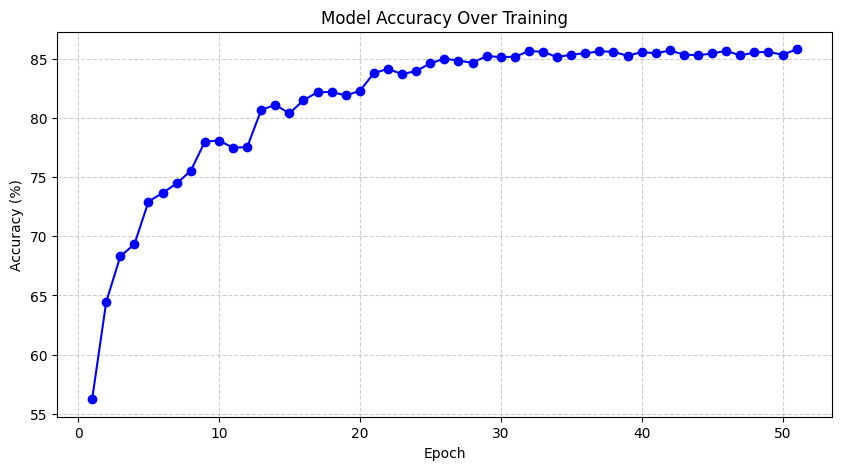

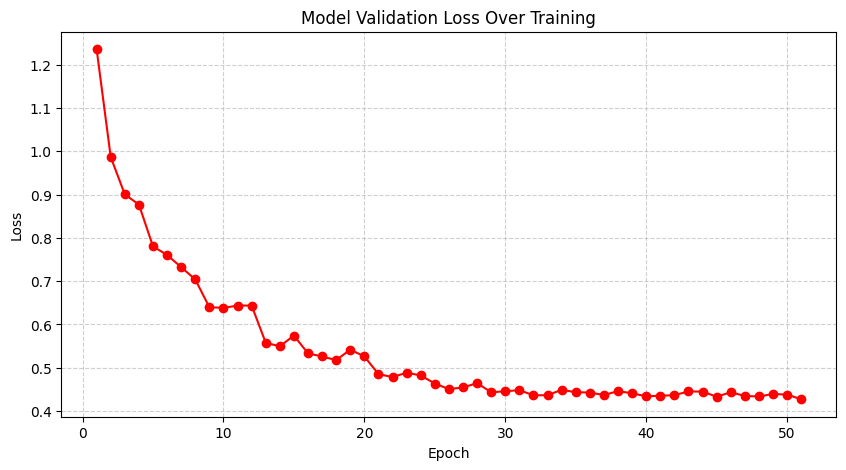

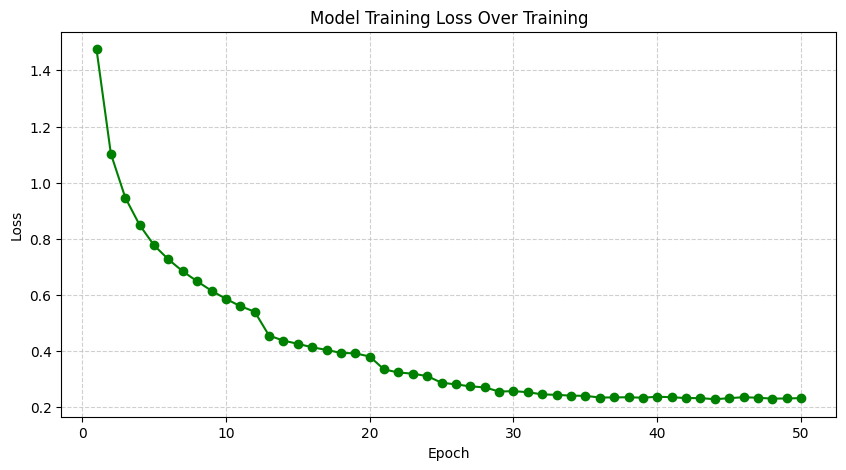

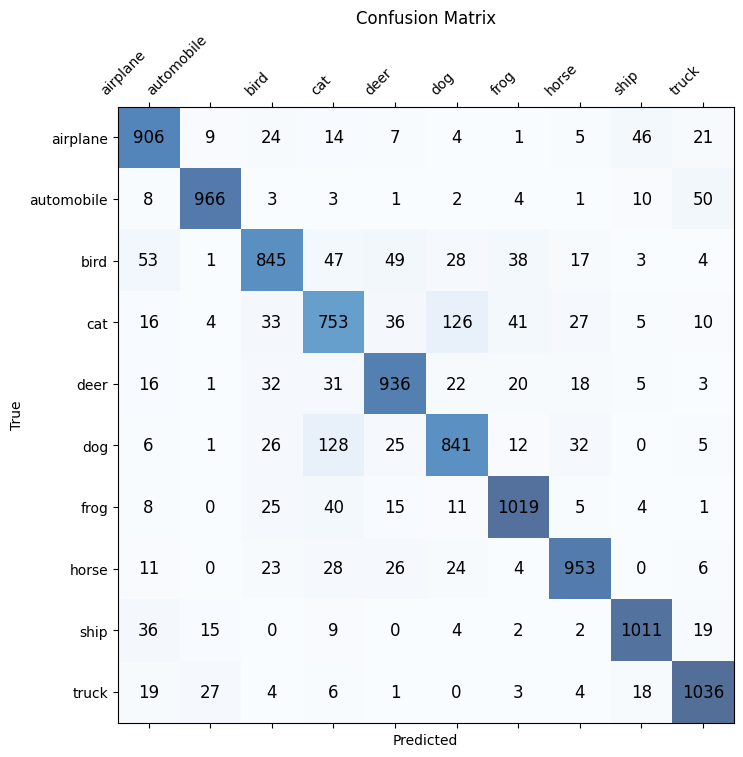


Classification Report:

              precision    recall  f1-score   support

    airplane       0.84      0.87      0.86      1037
  automobile       0.94      0.92      0.93      1048
        bird       0.83      0.78      0.80      1085
         cat       0.71      0.72      0.71      1051
        deer       0.85      0.86      0.86      1084
         dog       0.79      0.78      0.79      1076
        frog       0.89      0.90      0.90      1128
       horse       0.90      0.89      0.89      1075
        ship       0.92      0.92      0.92      1098
       truck       0.90      0.93      0.91      1118

    accuracy                           0.86     10800
   macro avg       0.86      0.86      0.86     10800
weighted avg       0.86      0.86      0.86     10800



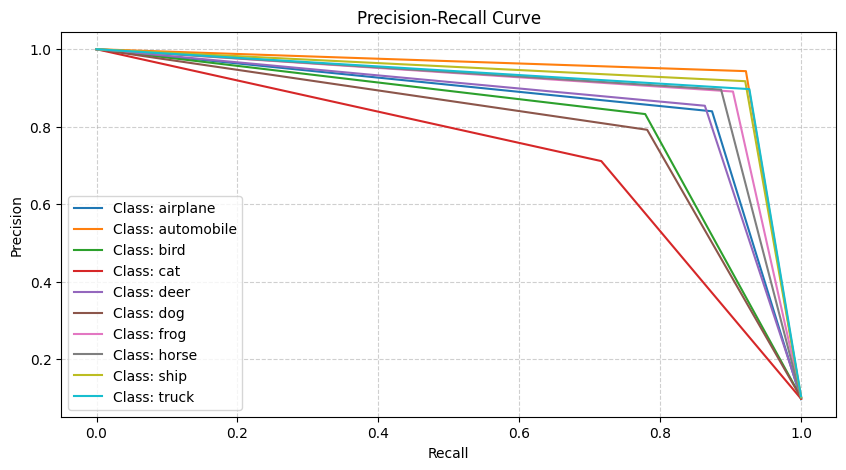

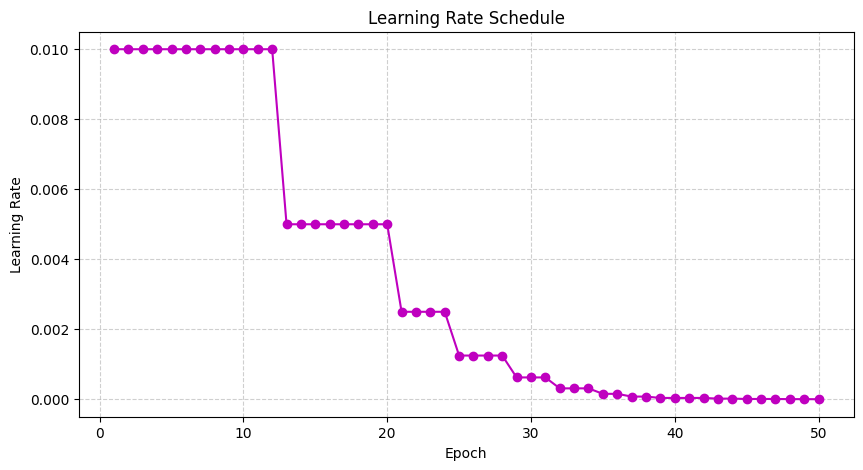

Top-5 Accuracy: 99.29%


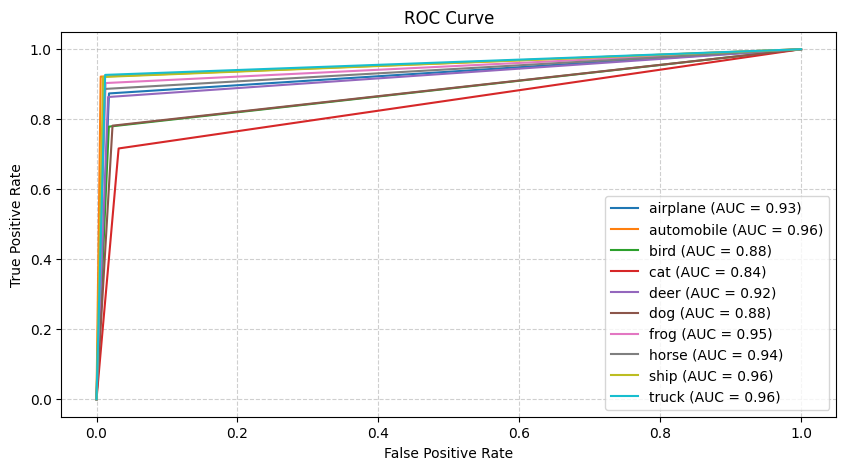

In [11]:
# Updated CNN Model
class OptimisedCNN(nn.Module):
    def __init__(self):
        super(OptimisedCNN, self).__init__()
        # Convolutional Layers
        self.convolution1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.normaliseBatch1 = nn.BatchNorm2d(32)
        
        self.convolution2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.normaliseBatch2 = nn.BatchNorm2d(64)
        
        self.convolution3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.normaliseBatch3 = nn.BatchNorm2d(128)
        
        # Added Fourth Convolutional Layer
        self.convolution4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.normaliseBatch4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
     #1
        #self.dropout = nn.Dropout(0.5) # 50% of neurons will be dropeed out during each forward pass in training
        #or use this one
        self.dropout = nn.Dropout(0.3) # 30% of neurons will be dropeed out during each forward pass in training

    #2
        #self.relu = nn.ReLU() #defines the activation functiuon ReLU to introduce non linearity, sets negative values to zero and keeps positive values. 
        #or use this one
        self.relu = nn.LeakyReLU(negative_slope=0.1) #leaky ReLU unlike ReLU allows a slight negative slope for negative inputs, preventing neurons from dying keeping them a little active.


    def forward(self, x):
        x = self.pool(self.relu(self.normaliseBatch1(self.convolution1(x))))
        x = self.pool(self.relu(self.normaliseBatch2(self.convolution2(x))))
        x = self.pool(self.relu(self.normaliseBatch3(self.convolution3(x))))
        x = self.pool(self.relu(self.normaliseBatch4(self.convolution4(x))))
        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialise Model, Loss, Optimizer, and Scheduler
OptimisedModel = OptimisedCNN().to(device)
criterion = nn.CrossEntropyLoss()

#3
#optimiser = optim.Adam(OptimisedModel.parameters(), lr=0.001) # auto adjusts learning rate for each parameter while training
#or use this one... could further change the learning rate lr to 0.005
optimiser = torch.optim.SGD(OptimisedModel.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) #traditional optimiser, adjusts parameters uniformly based on gradients, uses momentum and weight decay for stable and efficient updates

#4
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=3, verbose=True) #reduces learning rate when validation loss stops improving, does this dynamically to prevent stagnation
#or this one
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=0.01, steps_per_epoch=len(load_train), epochs= 10) #increases and decreases learning rate in cycles over the entire training, It has a triangular learning rate policy, lr goes up fast in the first phase, then peaks at max_lr and starts decaying to values near zero.


# Extract class labels from the original dataset
class_labels = torchvision.datasets.CIFAR10(root='./data', train=True, download=False).classes
 # This will give you the class names
# Create an instance of ModelEvaluator after training
evaluator = ModelEvaluator(OptimisedModel, optimiser, criterion, device, load_train, load_validation, load_test, class_labels)



# Increase Training Epochs
epochs = 50

# Training Loop
for epoch in range(epochs):
    OptimisedModel.train()
    running_loss = 0.0
    
    for inputs, labels in load_train:
        inputs, labels = inputs.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = OptimisedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss += loss.item()

    # Calculate average training loss and store it
    average_loss = running_loss / len(load_train)
    evaluator.train_losses.append(average_loss)  # Append to evaluator's train_losses
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {average_loss:.4f}")

    # Validation Check
    evaluator.evaluate_epoch(epoch)  # Evaluate on the validation set and store metrics
    evaluator.store_learning_rate()  # Track learning rate

    # Update the learning rate scheduler
    scheduler.step(evaluator.validation_losses[-1])  # Step using the last validation loss



    # Validation Check
    OptimisedModel.eval()
    validation_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in load_validation:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = OptimisedModel(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_validation_loss = validation_loss / len(load_test)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {average_validation_loss:.4f}, Accuracy: {accuracy:.2f}%")
    scheduler.step(average_validation_loss)

# Final Test Accuracy
OptimisedModel.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in load_test:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = OptimisedModel(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate OptimisedModel on the test set
evaluator.evaluate_epoch(epochs - 1)

# Call all evaluation methods
evaluator.plot_accuracy()               # Plot Accuracy
evaluator.plot_validation_loss()        # Plot Validation Loss
evaluator.plot_training_loss()          # Plot Training Loss
evaluator.plot_confusion_matrix()       # Confusion Matrix
evaluator.print_classification_report() # Classification Report
evaluator.plot_precision_recall_curve()# Precision-Recall Curve
evaluator.plot_learning_rate()          # Learning Rate Plot
evaluator.calculate_top5_accuracy()       # Top-5 Accuracy
evaluator.plot_roc_curve()              # ROC Curve

## Testing models on test set, and evaluate those results


Starting Test Evaluation and Comparison...

Testing Model: Base CNN
Model: Base CNN
Test Loss: 0.6891
Accuracy: 76.27%
Top-5 Accuracy: 98.17%

Classification Report for Base CNN:

              precision    recall  f1-score   support

    airplane       0.78      0.80      0.79       600
  automobile       0.80      0.94      0.86       579
        bird       0.62      0.76      0.68       622
         cat       0.63      0.57      0.60       583
        deer       0.71      0.80      0.75       580
         dog       0.76      0.60      0.67       621
        frog       0.76      0.87      0.81       571
       horse       0.83      0.79      0.81       642
        ship       0.84      0.89      0.86       586
       truck       0.97      0.63      0.77       616

    accuracy                           0.76      6000
   macro avg       0.77      0.76      0.76      6000
weighted avg       0.77      0.76      0.76      6000


-----------------------------------------------------------

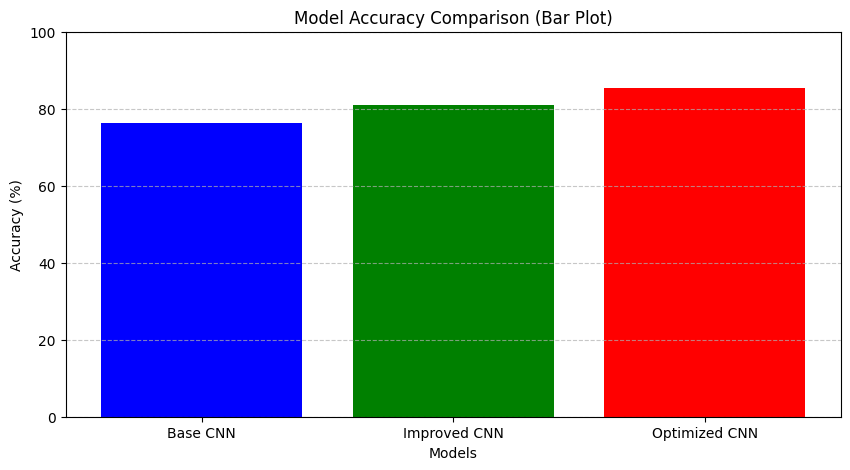

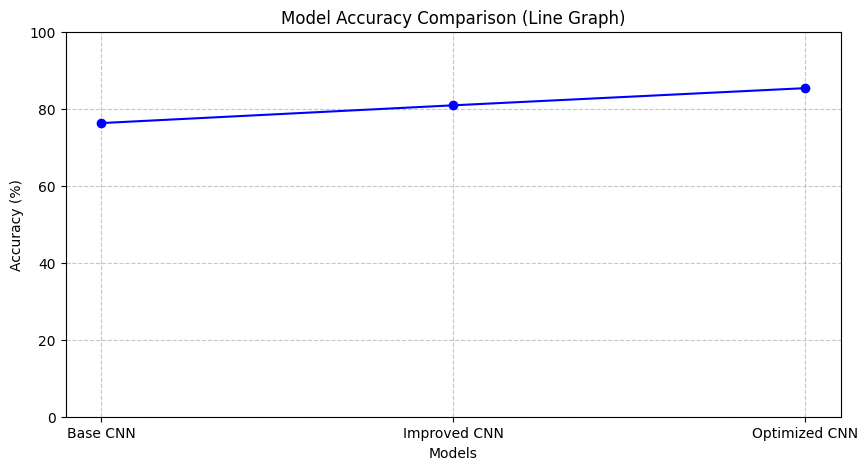

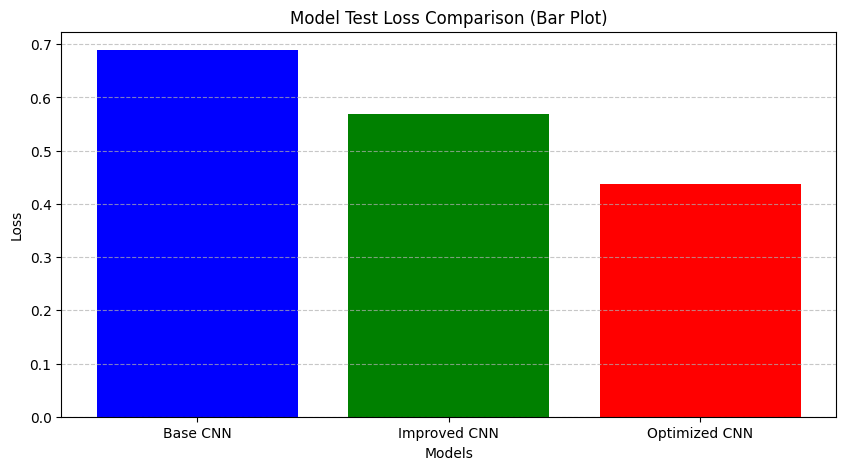

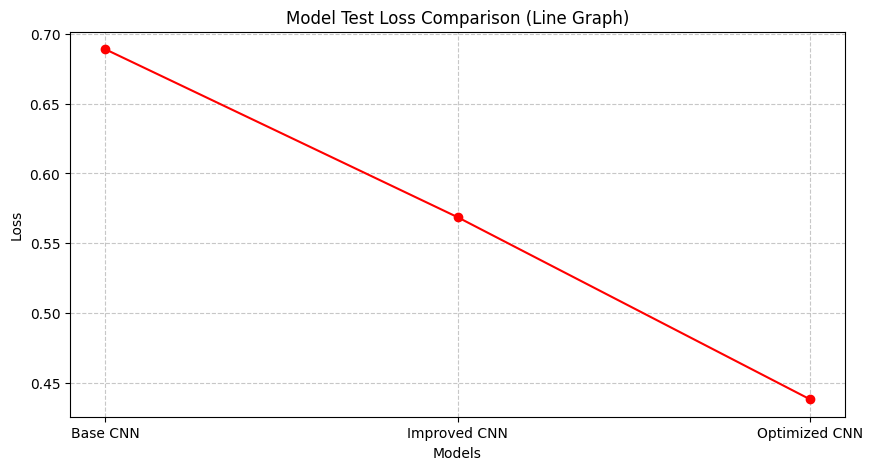

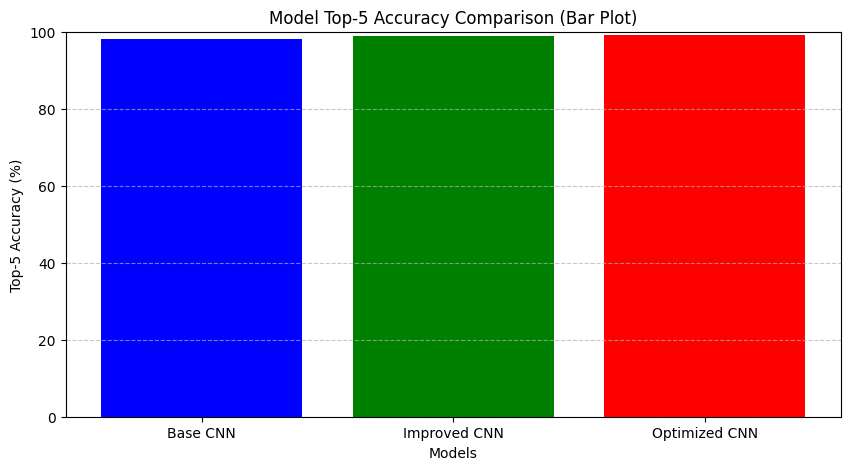

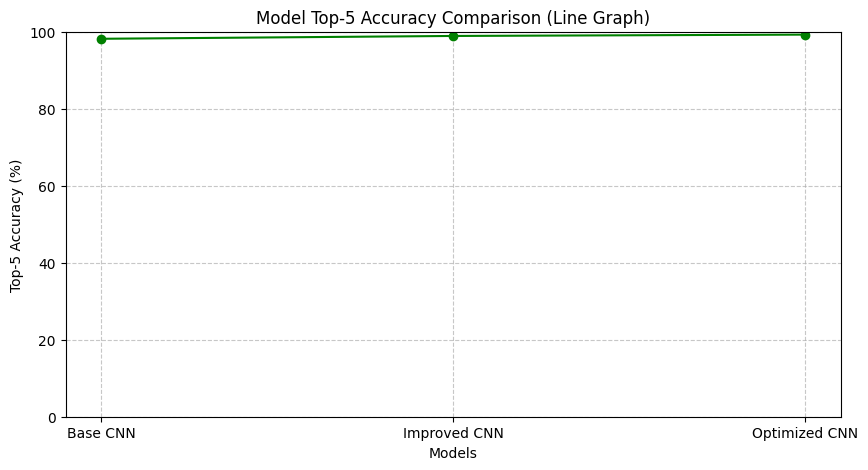

In [12]:

def test_and_compare_models(models, model_names, load_test, class_labels, criterion):
    print("\nStarting Test Evaluation and Comparison...\n")
    test_results = {}

    # Test each model on the test data
    for model, name in zip(models, model_names):
        print(f"Testing Model: {name}")
        model.eval()  # Switch to evaluation mode
        test_loss = 0.0
        correct, total = 0, 0
        correct_top5, total_top5 = 0, 0
        all_labels, all_predictions = [], []

        with torch.no_grad():
            for inputs, labels in load_test:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                _, top5_predictions = outputs.topk(5, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                correct_top5 += (top5_predictions == labels.unsqueeze(1)).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        # Compute metrics
        accuracy = 100 * correct / total
        top5_accuracy = 100 * correct_top5 / total
        average_test_loss = test_loss / len(load_test)

        # Print metrics to terminal
        print(f"Model: {name}")
        print(f"Test Loss: {average_test_loss:.4f}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")
        print(f"\nClassification Report for {name}:\n")
        print(classification_report(all_labels, all_predictions, target_names=class_labels))

        # Store results
        test_results[name] = {
            "Test Loss": average_test_loss,
            "Accuracy": accuracy,
            "Top-5 Accuracy": top5_accuracy,
            "Confusion Matrix": confusion_matrix(all_labels, all_predictions),
            "Classification Report": classification_report(all_labels, all_predictions, target_names=class_labels, output_dict=True)
        }
        print("\n" + "-"*60 + "\n")

    # Compare results with bar plots and line graphs
    print("\nGenerating Comparative Plots...\n")

    # Extract metrics for all models
    accuracies = [test_results[name]["Accuracy"] for name in model_names]
    test_losses = [test_results[name]["Test Loss"] for name in model_names]
    top5_accuracies = [test_results[name]["Top-5 Accuracy"] for name in model_names]

    # Accuracy Comparison - Bar Plot and Line Graph
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
    plt.title("Model Accuracy Comparison (Bar Plot)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(model_names, accuracies, marker='o', linestyle='-', color='b')
    plt.title("Model Accuracy Comparison (Line Graph)")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Test Loss Comparison - Bar Plot and Line Graph
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, test_losses, color=['blue', 'green', 'red'])
    plt.title("Model Test Loss Comparison (Bar Plot)")
    plt.ylabel("Loss")
    plt.xlabel("Models")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(model_names, test_losses, marker='o', linestyle='-', color='r')
    plt.title("Model Test Loss Comparison (Line Graph)")
    plt.ylabel("Loss")
    plt.xlabel("Models")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # Top-5 Accuracy Comparison - Bar Plot and Line Graph
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, top5_accuracies, color=['blue', 'green', 'red'])
    plt.title("Model Top-5 Accuracy Comparison (Bar Plot)")
    plt.ylabel("Top-5 Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(model_names, top5_accuracies, marker='o', linestyle='-', color='g')
    plt.title("Model Top-5 Accuracy Comparison (Line Graph)")
    plt.ylabel("Top-5 Accuracy (%)")
    plt.xlabel("Models")
    plt.ylim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    return test_results

# List of trained models and their names
models = [CNNModel, ImprovedModel, OptimisedModel]  # Ensure these are valid model instances
model_names = ["Base CNN", "Improved CNN", "Optimized CNN"]

# Run the test and comparison
test_results = test_and_compare_models(models, model_names, load_test, class_labels, criterion)
